<font size ="4">**Importing all the libraries**</font>

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os

from sklearn.metrics import confusion_matrix

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import neighbors , metrics , svm

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/u194149/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u194149/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/u194149/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [4]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [5]:
fake_data = pd.read_csv('data/Fake.csv')
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true_data = pd.read_csv('data/True.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Assigning Classes to the Dataset

In [7]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [8]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

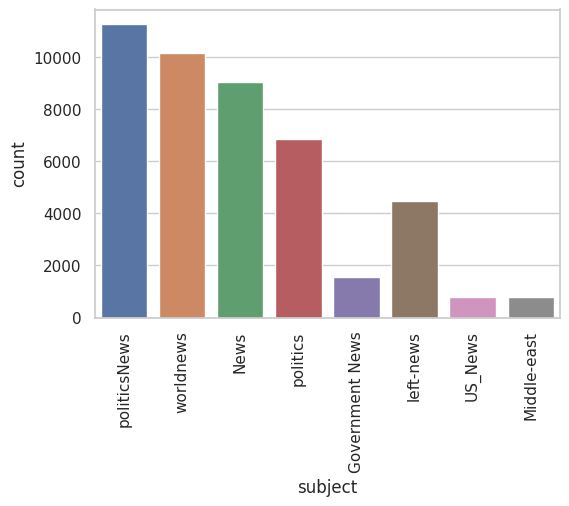

In [9]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<font size="4">**Data preprocessing**</font>

In [10]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [11]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [12]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [13]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [14]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,"In Kenya, polarizing election re-run rekindles...",1
1,Briton accused of terrorism offences posted pi...,1
2,UNESCO selects France's Azoulay as new chief P...,1
3,China offers support for strife-torn Venezuela...,1
4,Indonesia group pinpoints suspected mass grave...,1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

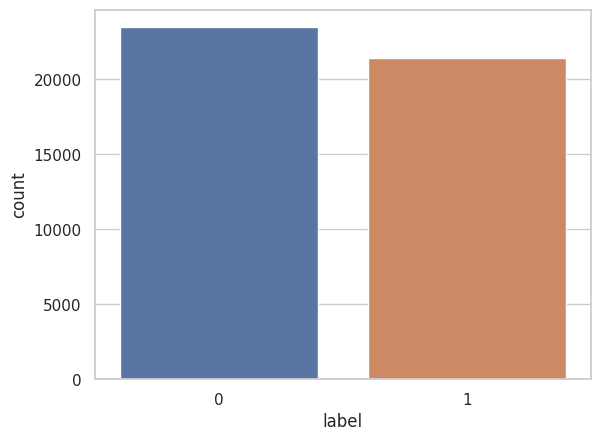

In [15]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

     Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as   input.

In [16]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def preprocess_text(text):
    
    text = text.lower()
    

    lemmatizer = WordNetLemmatizer()
    text = word_tokenize(text)

    for i in text:
        lemmatizer.lemmatize(i)
    
    stopword = set(stopwords.words('english'))
    stopword.update(list(string.punctuation))
    stopword.update(['"'])
    
    word = str()
    for i in text:
        if i not in stopword:
            word += i
            word += " "
    


    
    return word

data['text'] = data['text'].apply(preprocess_text)

<font size="4">**Converting text into Vectors**</font>

In [17]:
#TODO: explore different vectorization available with sklearn.feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

x , y = data['text'] , data['label']

vector = CountVectorizer()
x = vector.fit_transform(x)


<font size="4">**Spliting the data for the model**</font>

In [18]:
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = 0.2)

<font size="4">**Model training, Evaluation, and Prediction**</font>

<font size = 4>**Logistic Regression Model**<font>

      About Logistic Regression Model
              o	Logistic regression is one of the most popular Machine Learning algorithms, which comes under the Supervised Learning technique. It is used for predicting the categorical dependent variable using a given set of independent variables.
              
              o	Logistic regression predicts the output of a categorical dependent variable. Therefore the outcome must be a categorical or discrete value. It can be either Yes or No, 0 or 1, true or False, etc. but instead of giving the exact value as 0 and 1, it gives the probabilistic values which lie between 0 and 1.
              
              o	Logistic Regression is much similar to the Linear Regression except that how they are used. Linear Regression is used for solving Regression problems, whereas Logistic regression is used for solving the classification problems.
              
              o	In Logistic regression, instead of fitting a regression line, we fit an "S" shaped logistic function, which predicts two maximum values (0 or 1).
              
              o	The curve from the logistic function indicates the likelihood of something such as whether the cells are cancerous or not, a mouse is obese or not based on its weight, etc.
              
              o	Logistic Regression is a significant machine learning algorithm because it has the ability to provide probabilities and classify new data using continuous and discrete datasets.

                                                          1 / (1 + e^-value)
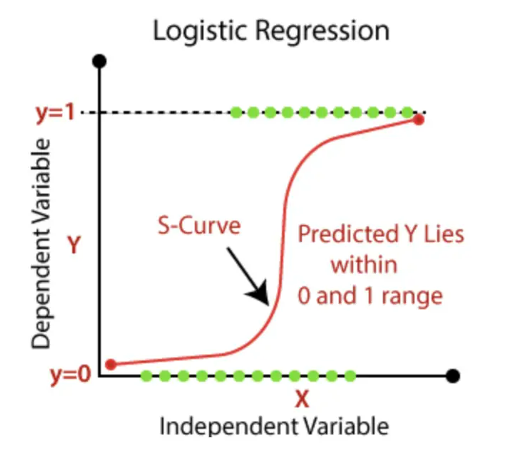

In [19]:
LR = LogisticRegression(max_iter = 200)
LR.fit(x_train , y_train)

LogisticRegression(max_iter=200)

In [20]:
scoreLogisticRegression = accuracy_score(LR.predict(x_test) , y_test)
print("The Accuracy Score of the LogisticRegression %.2f " % scoreLogisticRegression,end = "% out of 1.0")

The Accuracy Score of the LogisticRegression 1.00 % out of 1.0

In [21]:
print(classification_report(y_test , LR.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4681
           1       1.00      1.00      1.00      4299

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [22]:
dtc_pred = (LR.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixLR = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, LR.predict(x_test)):
    confusion_matrixLR[true][predict] += 1

print(confusion_matrixLR)

[[4665.   16.]
 [  11. 4288.]]


Text(0.5, 1.0, 'Logistic Regression ')

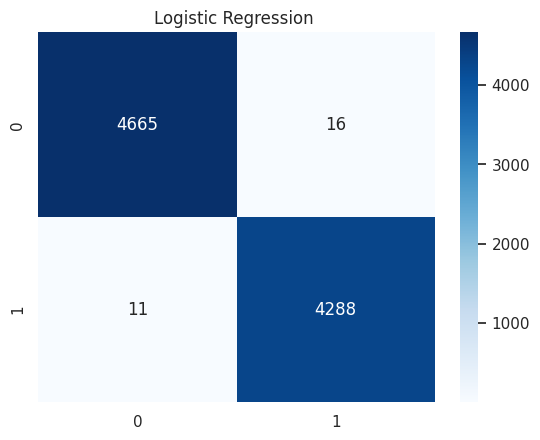

In [79]:
sns.heatmap(confusion_matrix(y_test,LR.predict(x_test)),annot=True,fmt='.0f',cmap='Blues')
plt.title("Logistic Regression ")

<font size = 4>**Decision Tree Classifier**<font>

**About Decision Tree Classifier Model**
      
    * A decision tree is a popular and widely used machine learning algorithm that resembles a flowchart-like structure, representing decisions and their possible consequences.
    * It is a predictive model used for classification and regression tasks.
    * The decision tree algorithm learns from labelled training data and builds a hierarchical structure of decision nodes and leaf nodes.
    
    * Difference between Decision tree classifier and other machine learning models
      1)Interpretability
        * Decision trees are highly interpretable models. The decision rules inferred from the tree structure can be easily understood and visualized
        * In contrast, some other models, like neural networks or support vector machines, are often considered black-box models, making it harder to interpret their decisions.
        
      2)Nonlinearity
        * Decision trees can capture nonlinear relationships between features and the target variable without requiring explicit feature transformations, This can be advantageous when the underlying data has complex nonlinear patterns.
      
      3)Generalization Performance
        * Decision trees have a tendency to overfit the training data, especially when the tree becomes deep and complex.
        

    * For Example to understand how the decision tree is been created for certain model
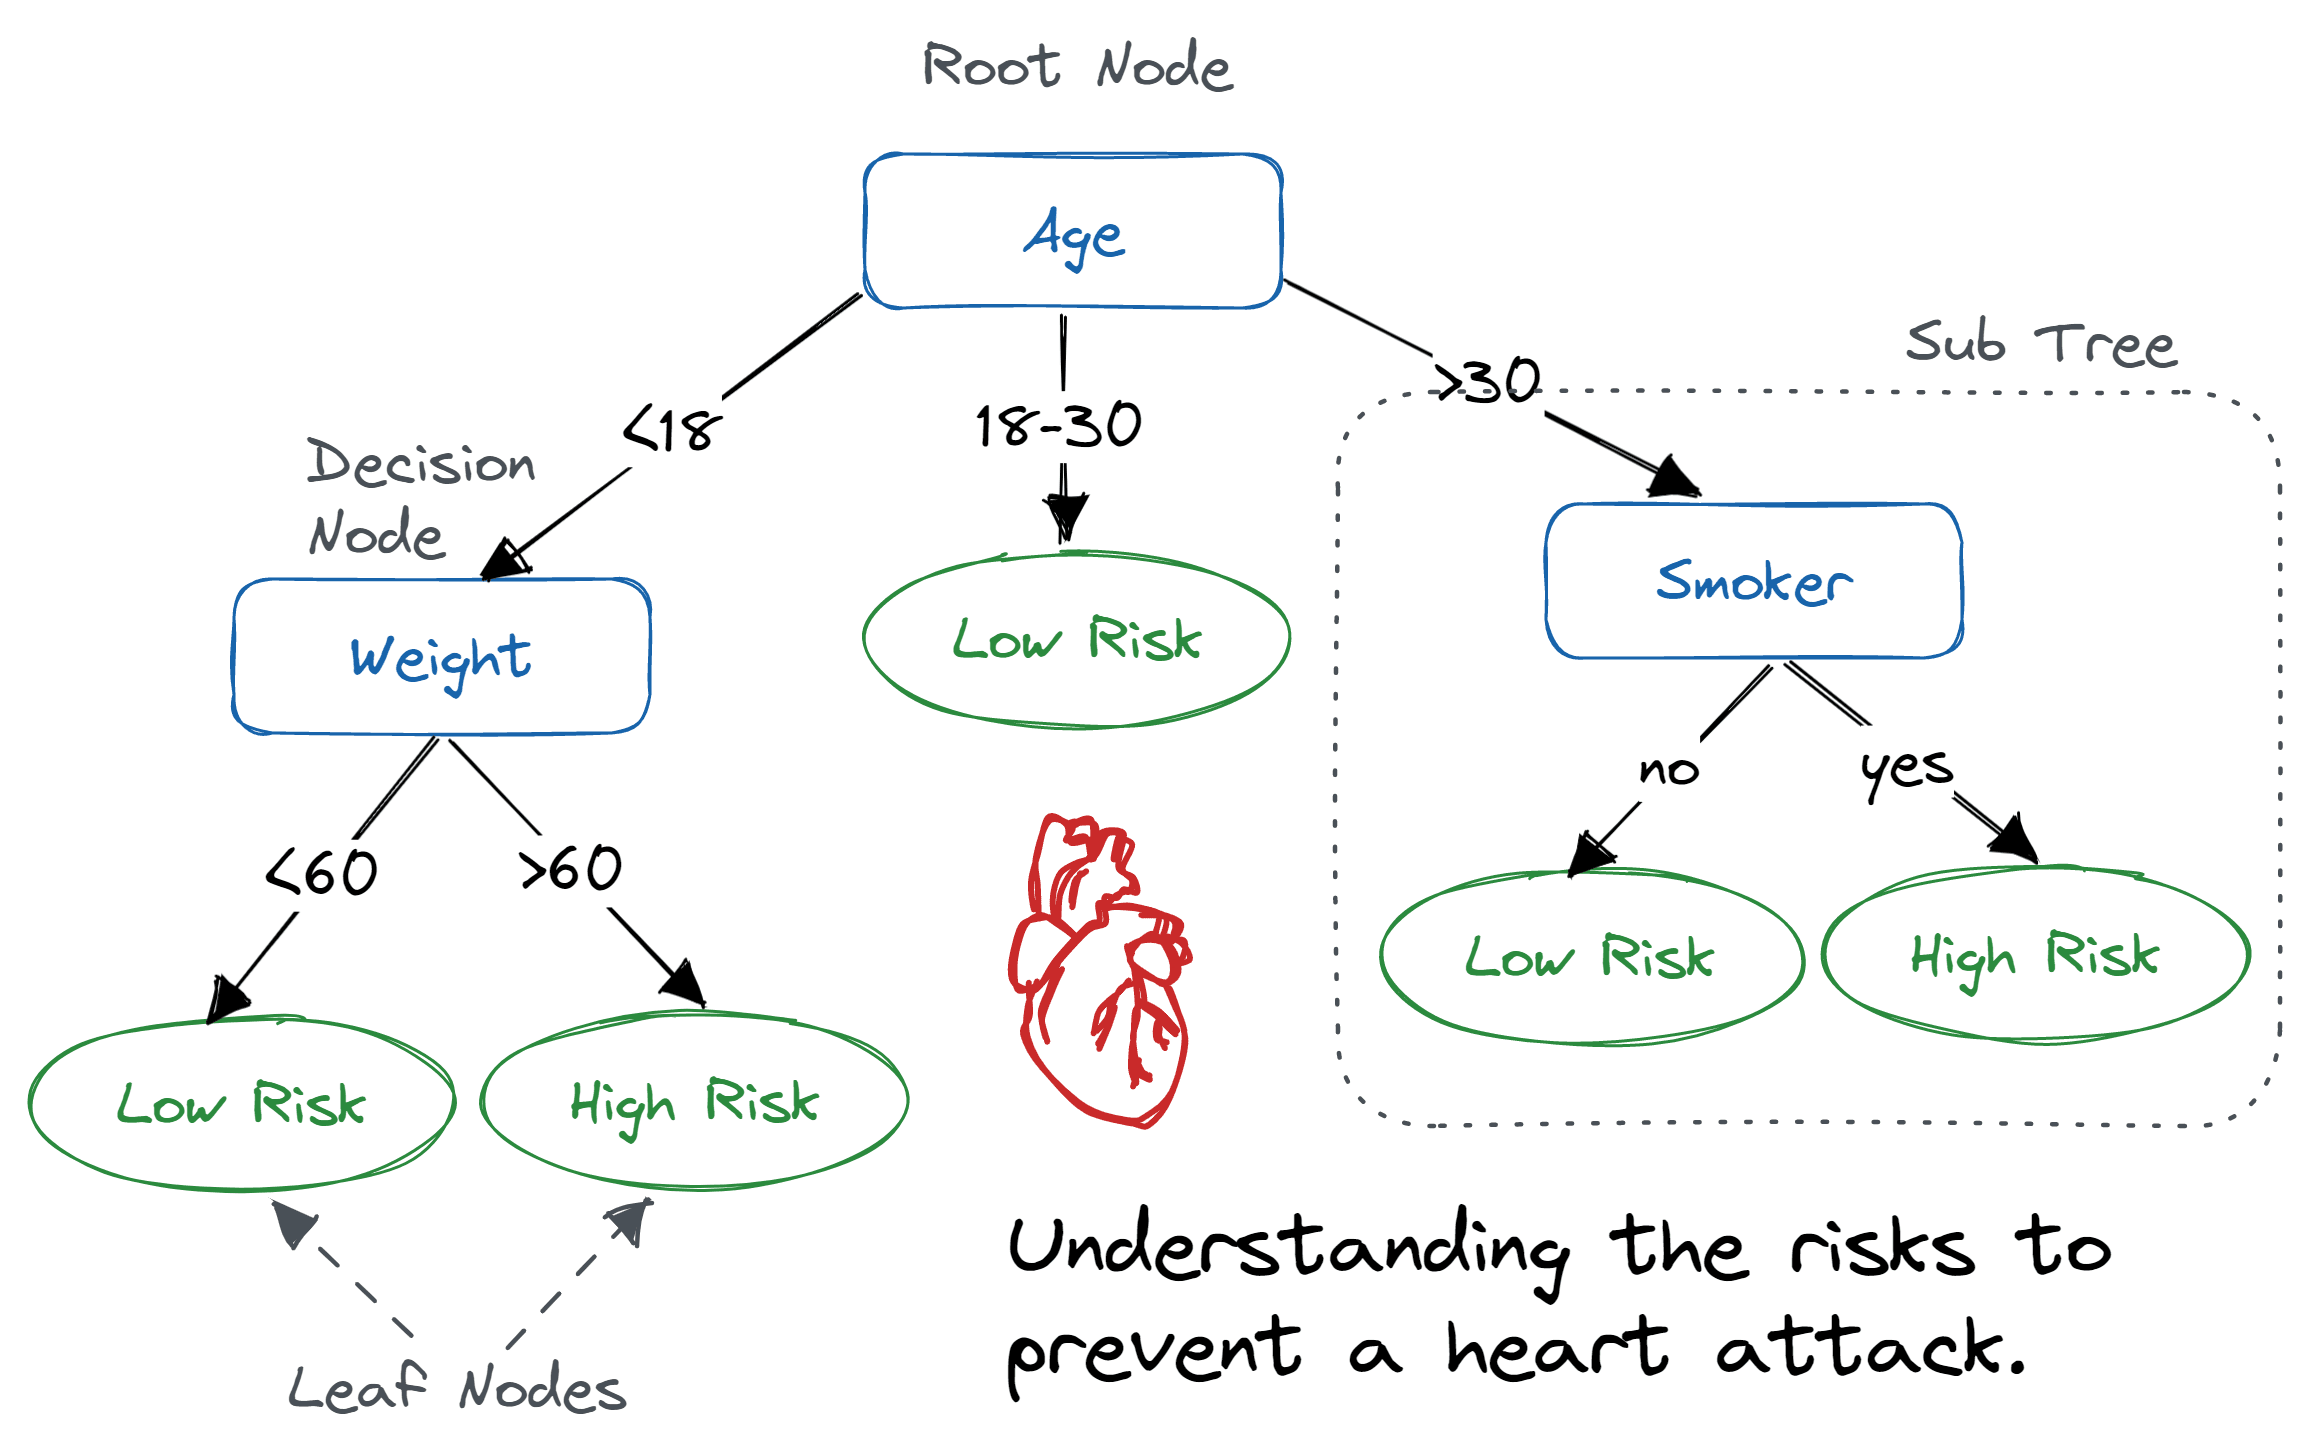

**Syntax of Decision Tree Classifier**
   
    1)DecisionTreeClassifier(criterion = 'entropy' , splitter = 'random') 
      1)criterion = 'entropy' : The function to measure the quality of a split.
         About criterion =  entropy
         
               * The entropy criterion computes the Shannon entropy of the possible classes. It takes the class frequencies of the training data points that reached a given leaf as their probability.
             
      2)splitter = 'random' : The strategy used to choose the split at each node. Supported strategies are “random” to choose the best random split.
    

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
DTC = DecisionTreeClassifier(criterion = 'entropy' , splitter = 'random')

In [25]:
DTC.fit(x_train , y_train)

DecisionTreeClassifier(criterion='entropy', splitter='random')

In [26]:
scoreDecisionTreeClassifier = accuracy_score(y_test , DTC.predict(x_test))
print("The Accuracy Score of the Decision Tree Classifier %.2f " % scoreDecisionTreeClassifier,end = "% out of 1.0")

The Accuracy Score of the Decision Tree Classifier 0.99 % out of 1.0

In [27]:
print(classification_report(DTC.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4688
           1       0.99      0.99      0.99      4292

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [28]:
dtc_pred = (DTC.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixDTC = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, DTC.predict(x_test)):
    confusion_matrixDTC[true][predict] += 1

print(confusion_matrixDTC)

[[4656.   25.]
 [  32. 4267.]]


Text(0.5, 1.0, 'Decision Tree Classifier')

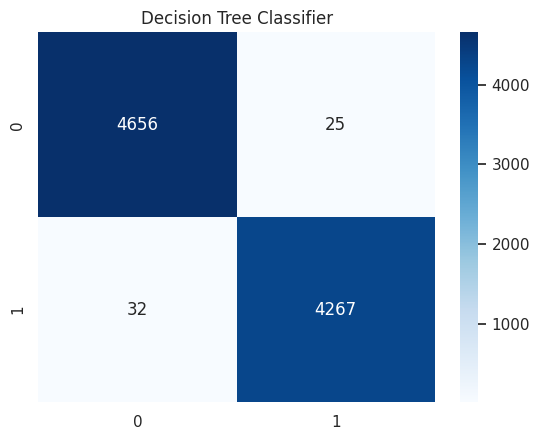

In [78]:
sns.heatmap(confusion_matrix(y_test,DTC.predict(x_test)),annot=True,fmt='.0f',cmap='Blues')
plt.title("Decision Tree Classifier")

<font size = 4>**Random Forest Algorithm**<font>

        * Random Forest is one of the most popular and commonly used algorithms by Data Scientists. 
        * Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems. 
        * It builds decision trees on different samples and takes their majority vote for classification and average in case of regression. The greater number of trees in the forest leads to higher accuracy and prevents the problem of overfitting.

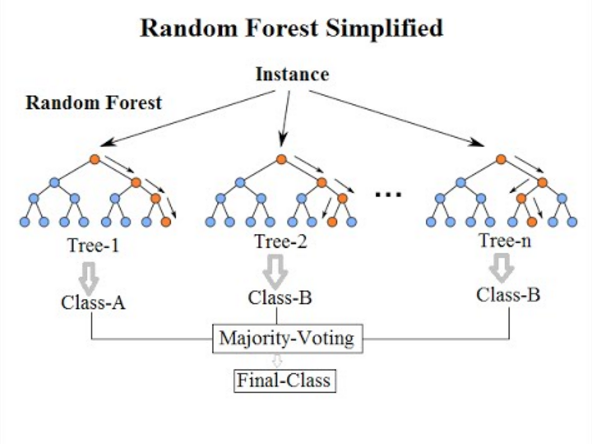

In [29]:
RF = RandomForestClassifier(criterion = 'gini' , max_depth = 8 , min_samples_split = 10 , random_state = 5)
RF.fit(x_train , y_train)

RandomForestClassifier(max_depth=8, min_samples_split=10, random_state=5)

In [30]:
scoreRandomForest = accuracy_score(RF.predict(x_test) , y_test)
print("The Accuracy Score of the Random Forest %.2f " % scoreRandomForest,end = "% out of 1.0")

The Accuracy Score of the Random Forest 0.96 % out of 1.0

In [31]:
print(classification_report(y_test , RF.predict(x_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4681
           1       0.98      0.93      0.95      4299

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [32]:
dtc_pred = (RF.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixRF = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, RF.predict(x_test)):
    confusion_matrixRF[true][predict] += 1

print(confusion_matrixRF)

[[4579.  102.]
 [ 285. 4014.]]


Text(0.5, 1.0, 'Random Forest')

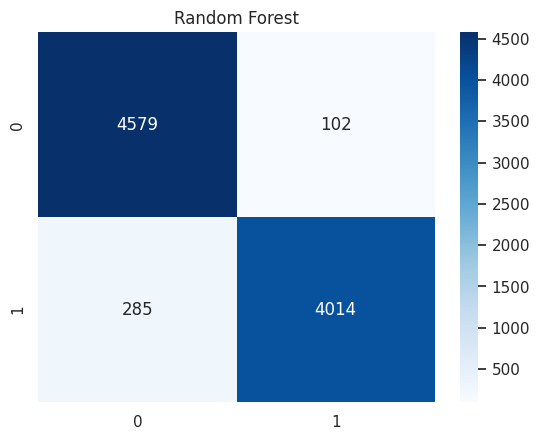

In [77]:
sns.heatmap(confusion_matrix(y_test,RF.predict(x_test)),annot=True,fmt='.0f',cmap='Blues')
plt.title("Random Forest")

<font size = 4>**Navie Bayes Algorithm**<font>

      Naive Bayes classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but a family of algorithms where all of them share a common principle, i.e. every pair of features being classified is independent of each other.
      
      The Naïve Bayes algorithm is comprised of two words Naïve and Bayes, Which can be described as:
           * Naïve: It is called Naïve because it assumes that the occurrence of a certain feature is independent of the occurrence of other features.
           * Bayes: It is called Bayes because it depends on the principle of Bayes' Theorem.
                        P(A|B) = P(B|A) * P(A) / P(B)
           * Where,
              * P(A|B) is Posterior probability: Probability of hypothesis A on the observed event B.
              * P(B|A) is Likelihood probability: Probability of the evidence given that the probability of a hypothesis is true.
              * P(A) is Prior Probability: Probability of hypothesis before observing the evidence.
              * P(B) is Marginal Probability: Probability of Evidence.

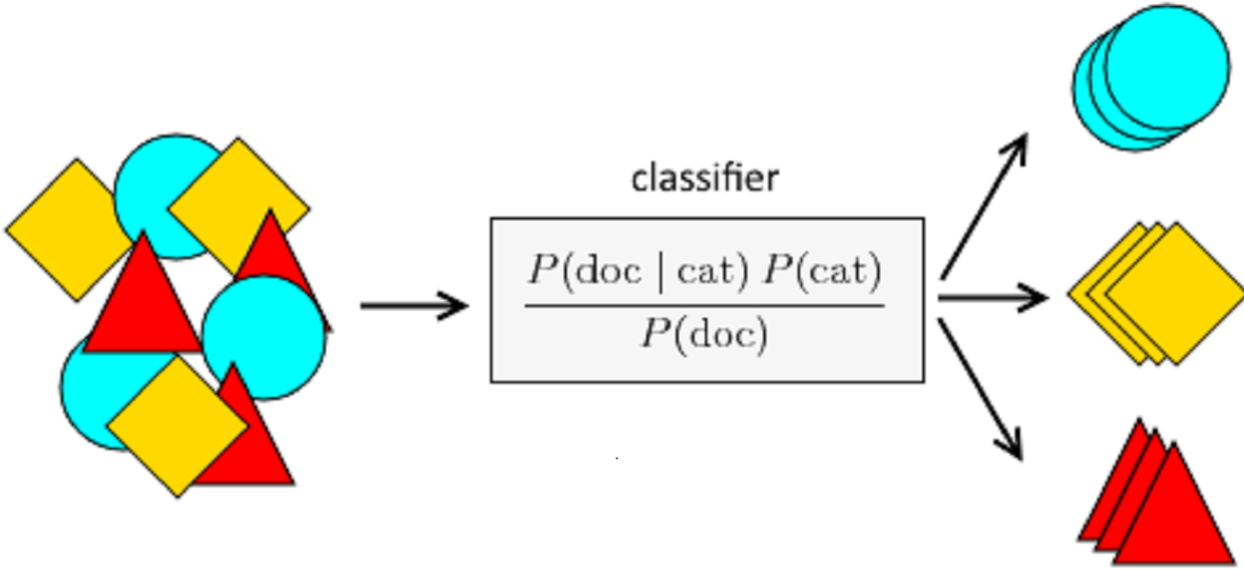

**About Multinomial Navie Bayes Model**
         
         * The multinomial distribution normally requires integer feature counts, but fractional counts such as tf-idf may also work.
         * MNB ignores the non-occurrence of features and is known to work well with text classification problems.
         * It is a probabilistic learning method that is mostly used in NLP and is one of the most popular supervised learning classifications used for the analysis of categorical text data.

In [33]:
NF = MultinomialNB()
NF.fit(x_train , y_train)

MultinomialNB()

In [34]:
scoreNavieBayes = accuracy_score(NF.predict(x_test) , y_test)
print("The Accuracy Score of the Navie Bayes %.2f " % scoreNavieBayes,end = "% out of 1.0")

The Accuracy Score of the Navie Bayes 0.96 % out of 1.0

In [35]:
print(classification_report(NF.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4711
           1       0.95      0.96      0.96      4269

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980



In [36]:
dtc_pred = (NF.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixNF = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, NF.predict(x_test)):
    confusion_matrixNF[true][predict] += 1

print(confusion_matrixNF)

[[4513.  168.]
 [ 198. 4101.]]


Text(0.5, 1.0, 'Navie Bayes')

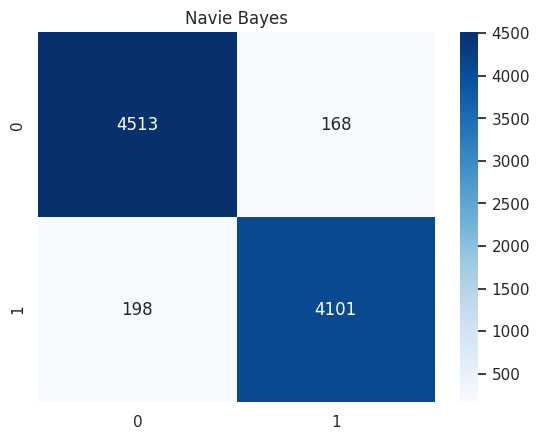

In [76]:
sns.heatmap(confusion_matrix(y_test,NF.predict(x_test)),annot=True,fmt='.0f',cmap='Blues')
plt.title("Navie Bayes")

<font size = 4>**Support Vector Machine**<font>

**About SVM**
  
    * SVM was a supervised classfication algorithm The goal of the SVM algorithm is to create the best line or decision boundary that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future.
    
    * SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors.
    
    * Separating Hyperplane: SVM aims to find an optimal hyperplane that separates the data points of different classes with the largest possible margin. The hyperplane is a decision boundary in the feature space.
    
    * Support Vectors: Support vectors are the data points that lie closest to the hyperplane. These points are critical in defining the decision boundary. Only the support vectors contribute to the construction of the SVM model, while other data points are ignored.
    
    
 
**Types of SVM**
       
    1. Linear Support Vector Machine
      * It was 2-dimensional space and the data will be segregate by using linear line as marign.
      * Compare the Non - Linear SVM the Linear model more simpler and efficient to predict the accurate data set.
      
    2. Non-Linear Support Vector Machine
      * It was 3-dimensional space and the data for 3d or more than 3-dimensional space will be using a 3d plane to segregate the data.
      * By using linear line could not able to segregate the data as marign but its also a 2d space then its also known as non-linear svm example parabola.
    

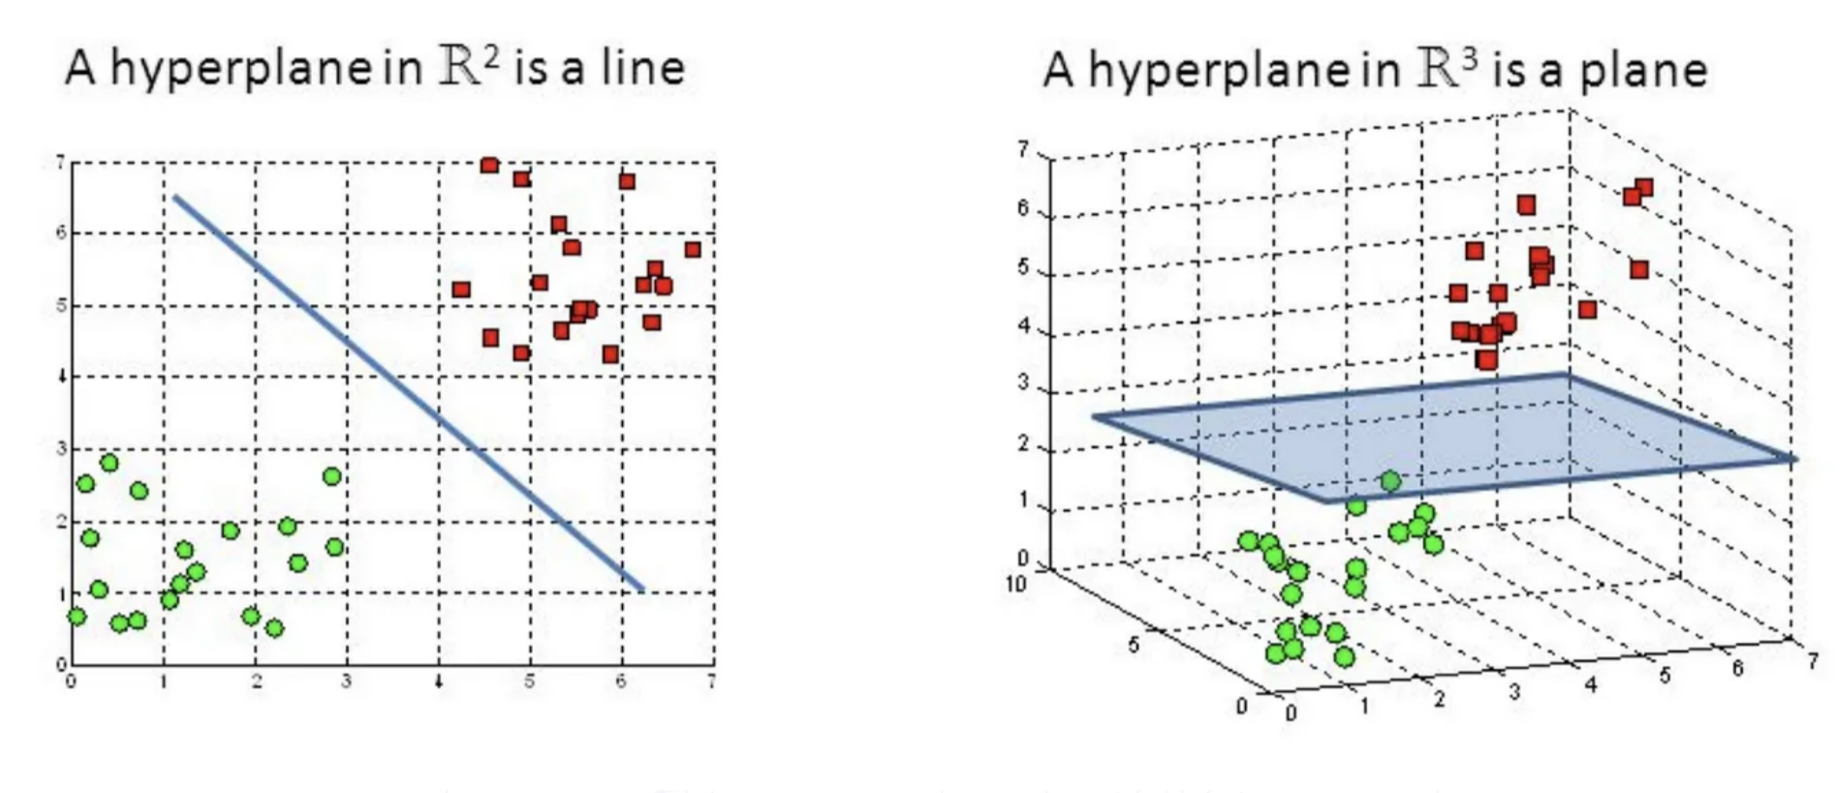

In [37]:
SVM = svm.SVC(kernel = 'linear' , random_state = 1)

In [38]:
SVM.fit(x_train , y_train)

SVC(kernel='linear', random_state=1)

In [39]:
scoreSupportVectorMachine = accuracy_score(SVM.predict(x_test) , y_test)
print("The Accuracy Score of the Support Vector Machine %.2f " % scoreSupportVectorMachine,end = "% out of 1.0")

The Accuracy Score of the Support Vector Machine 1.00 % out of 1.0

In [40]:
print(classification_report(SVM.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4664
           1       1.00      0.99      1.00      4316

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [41]:
dtc_pred = (SVM.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixSVM = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, SVM.predict(x_test)):
    confusion_matrixSVM[true][predict] += 1

print(confusion_matrixSVM)

[[4658.   23.]
 [   6. 4293.]]


Text(0.5, 1.0, 'Support Vector Machine')

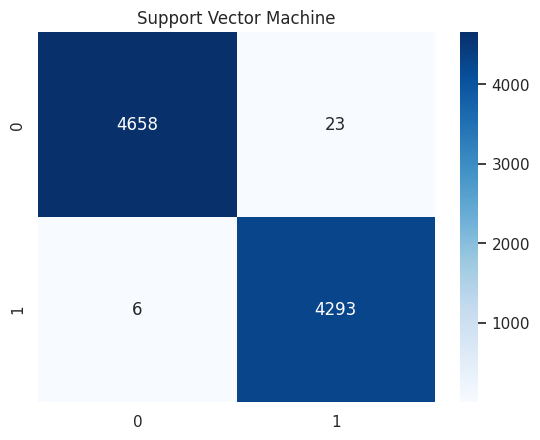

In [75]:
sns.heatmap(confusion_matrix(y_test,SVM.predict(x_test)),annot=True,fmt='.0f',cmap='Blues')
plt.title("Support Vector Machine")

<font size = 4>**Gradient Boosting**<font>



     About Boosting
         The principle behind boosting algorithms is first we built a model on the training dataset, then a second model is built to rectify the errors present in the first model.
         
         Gradient Boosting is a popular machine learning algorithm used for image classification. 
         It is built on the principles of the gradient tree boosting algorithm and is designed for speed and performance. 
         CNNs are known for their ability to extract features from images through their convolutional and pooling layers, which are then fed to a fully connected neural network that performs the classification task.

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators = 900 , max_features = 5 , learning_rate = 1.2 , random_state = 5)
GB.fit(x_train , y_train)

GradientBoostingClassifier(learning_rate=1.2, max_features=5, n_estimators=900,
                           random_state=5)

In [43]:
scoreGradientBoost = accuracy_score(GB.predict(x_test) , y_test)
print("The Accuracy Score of the Gradient Boosting %.2f " % scoreGradientBoost,end = "% out of 1.0")

The Accuracy Score of the Gradient Boosting 0.92 % out of 1.0

In [44]:
dtc_pred = (GB.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixGB = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, GB.predict(x_test)):
    confusion_matrixGB[true][predict] += 1

print(confusion_matrixGB)

[[4354.  327.]
 [ 402. 3897.]]


Text(0.5, 1.0, 'Gradient Boosting')

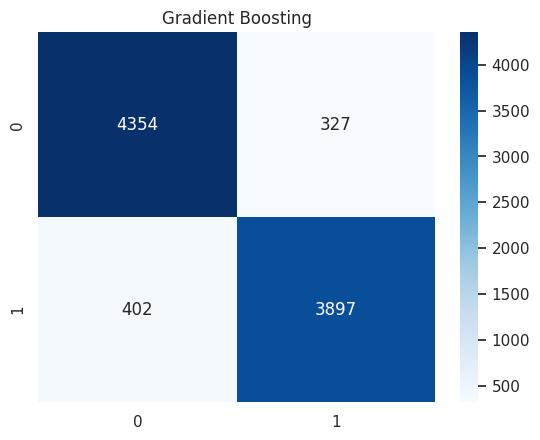

In [74]:
sns.heatmap(confusion_matrix(y_test,GB.predict(x_test)),annot=True,fmt='.0f',cmap='Blues')
plt.title("Gradient Boosting")

<font size = 4>**Neural Network**<font>

**About Tensorflow and Keras**
 
    TensorFlow is a free and open-source software library for machine learning and artificial intelligence. It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks.
    
    Keras Keras was API used for the tensorflow to build the neural network in fast and efficient way which include all the necessary methods and class's.
   

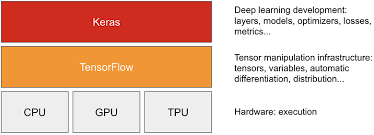

**What is Neural Network**
      
      * Its a technique for building a computer program that learns from data. It is based very loosely on how we think the human brain works.
      
      * Neural networks and deep learning currently provide the best solutions to many problems in image recognition, speech recognition, and natural language processing. 
      
      * About Neurons  Each neuron is a mathematical function that computes the weighted average of its input, and this sum is passed through a nonlinear function, often called an activation function, such as the sigmoid.
      
      * Each Neuron will be connected to next layers neuron and each connection will be in different weights which helps to carry the embedded numeric data
 
**About Sequential Model Neural Network**
       
      * A Sequential model is a type of neural network architecture that is commonly used for building deep learning models. 
      
      * It is a linear stack of layers, where the output of each layer is passed as the input to the next layer. 
      
      * Sequential models are easy to define and understand, making them suitable for many common deep learning tasks.

                               

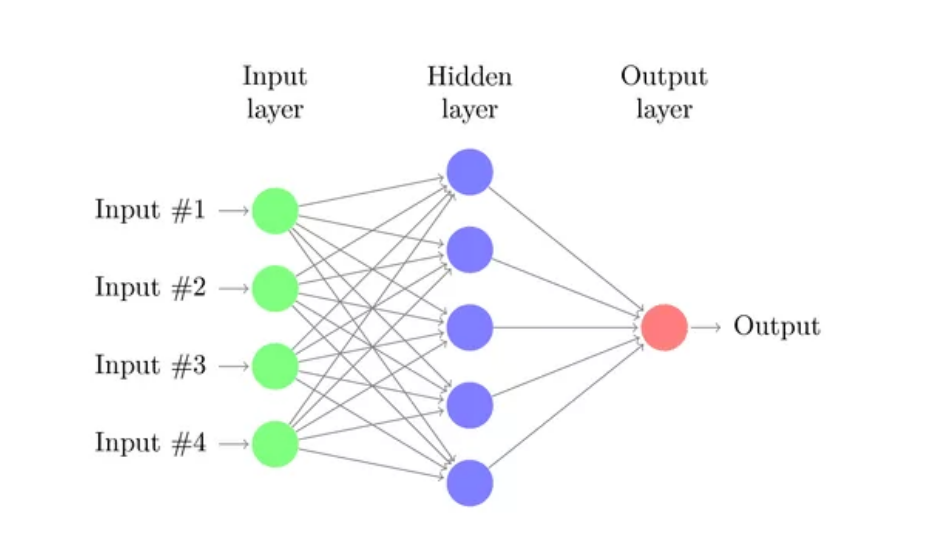

**Layers of Neural Network**
     
     1) Input Layer 
        The input layer of a neural network is the initial layer that receives the input data and passes it forward through the network for processing, Which helps to carry the data into the neural network and pass's to the next layer of the neural network.
     
     2) Hidden Layer
        A hidden layer in a neural network is a layer that comes between the input layer and the output layer. It is called a "hidden" layer because its neurons and their computations are not directly exposed to the external world or the input/output data. The hidden layer enable the network to learn complex patterns and representations from the input data.The number of hidden layers and the number of neurons in each hidden layer are design choices that depend on the specific problem and the complexity of the data.
     
     3) Output Layer
        The output layer in a neural network is the final layer that produces the network's output or predictions. It is responsible for mapping the learned representations from the preceding layers to the desired output format, depending on the specific task.

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-07-14 05:05:28.785285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 05:05:31.404318: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-14 05:05:31.421877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 05:05:51.727127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-14 05:06:27.265499: E itex/core/kernels/xpu_kernel.cc:38] XPU-GPU kernel not supported.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues


**Storing the data set into numpy array as text and label**

In [46]:
text = np.array(data['text'])

In [47]:
label = np.array(data['label'])

In [48]:
token = Tokenizer()
token.fit_on_texts(text)
word_index = token.word_index
vocab_size = len(word_index) + 1

In [49]:
sequence = token.texts_to_sequences(text)

In [50]:
max_length = max([len(seq) for seq in sequence])

In [51]:
padded = pad_sequences(sequence , maxlen = max_length)

In [52]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size , 20 , input_length = max_length , name = "Embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(20 , activation = 'relu'),
    tf.keras.layers.Dense(1 , activation = 'sigmoid')
])

In [53]:
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

In [54]:
paddedX_train ,paddedX_test ,paddedY_train ,paddedY_test = train_test_split(padded , label , test_size = 0.3)

In [55]:
model.fit(paddedX_train , paddedY_train , epochs = 7)

2023-07-14 05:07:00.995571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


Epoch 1/7


2023-07-14 05:07:01.246581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 05:07:01.298029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 05:07:01.960798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


983/983 [==============================] - 41s 39ms/step - loss: 0.5363 - accuracy: 0.7537
Epoch 2/7
983/983 [==============================] - 38s 39ms/step - loss: 0.1312 - accuracy: 0.9790
Epoch 3/7
983/983 [==============================] - 38s 39ms/step - loss: 0.0640 - accuracy: 0.9884
Epoch 4/7
983/983 [==============================] - 38s 39ms/step - loss: 0.0396 - accuracy: 0.9936
Epoch 5/7
983/983 [==============================] - 38s 39ms/step - loss: 0.0267 - accuracy: 0.9955
Epoch 6/7
983/983 [==============================] - 39s 39ms/step - loss: 0.0192 - accuracy: 0.9969
Epoch 7/7
983/983 [==============================] - 38s 39ms/step - loss: 0.0141 - accuracy: 0.9980


In [56]:
scoreNeuralNetwork = model.evaluate(paddedX_test , paddedY_test , verbose = 0)

2023-07-14 05:11:32.287015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 05:11:32.293774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 05:11:32.305152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 05:11:32.662414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


In [57]:
print("The Accuracy Score of the Neural Network of Sequential Model %.2f " % scoreNeuralNetwork[1],end = "% out of 1.0")

The Accuracy Score of the Neural Network of Sequential Model 0.99 % out of 1.0

In [58]:
dict = {
    "LR" : [int(scoreLogisticRegression* 100)],
    "NN" : [int(scoreNeuralNetwork[1] * 100)],
    "GB" : [int(scoreGradientBoost* 100)],
    "SVM": [int(scoreSupportVectorMachine* 100)],
    "NB" : [int(scoreNavieBayes* 100)],
    "RF" : [int(scoreRandomForest* 100)],
    "DTC":[int(scoreDecisionTreeClassifier* 100)]
}


In [59]:
scoreDataSet = pd.DataFrame(dict)
scoreDataSet

,LR,NN,GB,SVM,NB,RF,DTC
0,99,99,91,99,95,95,99


In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 5182, 20)          2523520   
                                                                 
 global_average_pooling1d (G  (None, 20)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,523,961
Trainable params: 2,523,961
Non-trainable params: 0
_________________________________________________________________


**Accuracy of Models**

<Axes: >

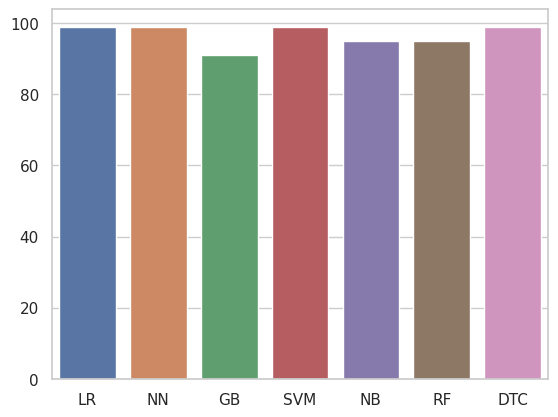

In [60]:
sns.barplot(data = scoreDataSet , width = 0.8)